# Predicting bike rentals with decision trees and random forest

In [1]:
# importing relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression


### Introduction

The goal of this project is to predict bike rentals using decision trees and random forest algorithms. We are going to use data from a bicycle sharing system to predict the total number of bikes rented in a given hour of a specific day.

This is an expansion of a guided project from the **Data Scientist in Python** career path in Dataquest. Hadi Fanaee-T at the University of Porto compiled this dataset using data from Capital Bikeshare, a bicycle sharing system that serves the metropolitan area of Washington DC, together with weather and holiday data from other sources. It can be downloaded from http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

### Data exploration and preparation

Let's start by reading in the data and having a first look at it. 

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')

In [3]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


According to the dataset description, each row represents the number of bike rentals for a single hour of a single day (`cnt` column). 

In [4]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


Here is the columns description from the link above: 

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

Our target is the `cnt` (for "count") variable. That is, the idea is to predict the `cnt` column using data from all the other columns except for `casual` and `registered`, since these two can also be seen as composing elements of our target variable of `cnt`, so we must exclude them. 

Let's start by having a quick look at the distribution of values of the `cnt` column.

([<matplotlib.axis.XTick at 0x254a974c248>,
 <a list of 10 Text xticklabel objects>)

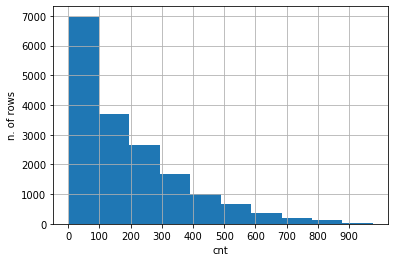

In [5]:
bike_rentals['cnt'].hist(bins=10)
plt.xlabel('cnt')
plt.ylabel('n. of rows')
plt.xticks(ticks=range(0, 1000, 100))


It seems most days have a user count of less than 200, although some days it can reach close to 1000. 

In [6]:
print('First row is', bike_rentals['dteday'].iloc[0], 'and the last one:', bike_rentals['dteday'].iloc[-1])

First row is 2011-01-01 and the last one: 2012-12-31


We can also see that the data spans two entire years - 2011 and 2012. 

Text(2012-06-01, 100, '2012')

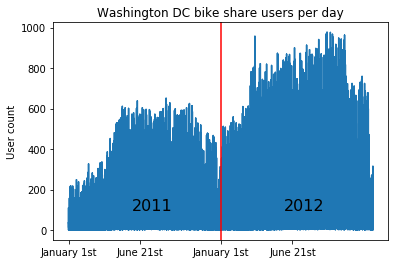

In [7]:
plt.plot(bike_rentals['dteday'], bike_rentals['cnt'])
plt.title('Washington DC bike share users per day')
plt.axvline('2012-01-01', color='red')
plt.xticks(ticks=['2011-01-01', '2011-06-21',
                  '2012-01-01', '2012-06-21'],
           labels=['January 1st', 'June 21st',
                   'January 1st', 'June 21st'])
plt.ylabel('User count')
plt.text('2011-06-01', 100, '2011', color='black', fontsize=16)
plt.text('2012-06-01', 100, '2012', color='black', fontsize=16)


From a quick look at the data, we can see that there seems to be a seasonal aspect to it - we have less users in the winter and more in the warmer months. We can also see that the overall number of users seem to have grown from one year to the other.

Hopefully, our model can capture that seasonal dynamics and incorporate it in its predictions.

In [8]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

We could simplify the `hr` column by dividing it into categories. From the point of view of the machine learning models we want to build, there is not much difference between 5 pm and 6 pm. It's better if we group the hours according to time of the day, like "morning", "afternoon", "evening" and "night". 

Let's create a function that helps us tranform this feature. We'll add a new column called `time_label`. 

In [9]:
def assign_label(hour):
    if 6 <= hour < 12:
        return 1 # morning
    if 12 <= hour < 18:
        return 2 # afternoon
    if 18 <= hour < 24:
        return 3 # evening
    if 0 <= hour < 6:
        return 4 # night

bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

Before we go any further with the feature engineering, we should divide our data into a training and a test set. 

In [10]:
np.random.seed(42) # make sure our results can be reproduced
train = bike_rentals.sample(frac=.8).copy() # 80 % of the data, randomly chosen, for training set
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)].copy() # the remaining 20 % of rows for the test set

Now let's make a list with the features we are going to use to predict the rentals.

In [11]:
features = list(train.columns)

In [12]:
features

['instant',
 'dteday',
 'season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'cnt',
 'time_label']

The exact day is not a relevant piece of information to predict our target variable. We already talked about a similar issue about the exact hour. Therefore, we'll exclude those columns variables from our features. Let's also remove the `instant` column which is just an index. 

In [13]:
to_remove = ['instant', 'casual', 'registered', 'dteday', 'hr', 'cnt']
for f in to_remove:
    features.remove(f)

In [14]:
# check remaining features

features

['season',
 'yr',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'time_label']

In [15]:
# set our target column

target = 'cnt'

### Model building

Our first model will be a simple linear regression that we can later use as a baseline for comparison.

In [16]:
lr = LinearRegression()

In [17]:
lr.fit(train[features], train[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Let's try it on the test set. 

In [18]:
test_predictions = lr.predict(test[features])

For the error metric, we'll use Mean Squared Error, since our target variable carries continuous numerical values. 

In [19]:
test_error = mean_squared_error(test_predictions, test['cnt'])

In [20]:
test_error

19567.179394914525

Let's also use our model on the training set.

In [21]:
train_predictions = lr.predict(train[features])

In [22]:
train_error = mean_squared_error(train_predictions, train['cnt'])

In [23]:
train_error

19235.73246678655

In [24]:
# add predictions to dataframe
test['predictions'] = test_predictions

It's hard to extract some information from just the MSE without having any other results to compare it to. We can have a look at some random samples from the test set to eyeball how close our predictions were to the target. 

In [25]:
test.sample(20)[['cnt', 'predictions']]

,cnt,predictions
6928,233,200.909325
17359,3,1.810955
1241,89,-24.875866
7710,90,58.554532
10395,121,220.397266
3225,257,128.426129
13373,186,416.046686
806,44,-43.073868
6185,329,189.435403
2261,17,-50.499171


While some predictions are close to the target, several are far off. Probably our linear model is too simple to capture the complexity of the data. 

Let's see how well a decision tree algorithm performs instead.

In [26]:
from sklearn.tree import DecisionTreeRegressor

In [27]:
tree = DecisionTreeRegressor()

In [28]:
tree.fit(train[features], train[target])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [29]:
test_predictions = tree.predict(test[features])

In [30]:
test_error = mean_squared_error(test_predictions, test[target])

In [31]:
test_error

22034.444808048844

In [32]:
train_predictions = tree.predict(train[features])

In [33]:
train_error = mean_squared_error(train_predictions, train[target])

In [34]:
train_error

318.29441487448753

Decision trees can model non-linear relationships in the data. They also tend overfit the training data. That seems to be the case, since there is a huge difference between the error of the training set predictions and that of the test set. 

Our first decision tree model actually performed worse on the test set than our first linear regression model. We should tweak the hyperparameters a bit to see if we can improve it. Let's start with the minimum samples per leaf parameter. We'll create models with different values for this hyperparameter and see how well they do.

In [35]:
msl_list = [n for n in range(1, 101)]
results = {}

In [36]:
for msl in msl_list:
    tree = DecisionTreeRegressor(min_samples_leaf=msl)
    tree.fit(train[features], train[target])
    predictions = tree.predict(test[features])
    error = mean_squared_error(predictions, test[target])
    results['min_samples_leaf ' + str(msl)] = error

In [37]:
results

{'min_samples_leaf 1': 21954.87155175169,
 'min_samples_leaf 2': 18749.85872195052,
 'min_samples_leaf 3': 17671.235608918312,
 'min_samples_leaf 4': 16883.949942354146,
 'min_samples_leaf 5': 16090.394591556962,
 'min_samples_leaf 6': 15696.961265369786,
 'min_samples_leaf 7': 15468.166216073512,
 'min_samples_leaf 8': 15411.79497636741,
 'min_samples_leaf 9': 15087.03724437417,
 'min_samples_leaf 10': 14834.875240379437,
 'min_samples_leaf 11': 14651.277024161276,
 'min_samples_leaf 12': 14569.724367442079,
 'min_samples_leaf 13': 14690.651671179436,
 'min_samples_leaf 14': 14717.680866938575,
 'min_samples_leaf 15': 14563.453954844776,
 'min_samples_leaf 16': 14510.745234329766,
 'min_samples_leaf 17': 14542.21474441137,
 'min_samples_leaf 18': 14558.030069530012,
 'min_samples_leaf 19': 14460.16251345166,
 'min_samples_leaf 20': 14346.816884226686,
 'min_samples_leaf 21': 14313.482339056027,
 'min_samples_leaf 22': 14359.48143461125,
 'min_samples_leaf 23': 14222.338359067184,
 'mi

In [38]:
y = list(results.values())

In [39]:
x = range(1, 101)

In [40]:
print(pd.DataFrame({'min_samples_leaf': x, 'MSE': y}).to_string(index=False))

 min_samples_leaf           MSE
                1  21954.871552
                2  18749.858722
                3  17671.235609
                4  16883.949942
                5  16090.394592
                6  15696.961265
                7  15468.166216
                8  15411.794976
                9  15087.037244
               10  14834.875240
               11  14651.277024
               12  14569.724367
               13  14690.651671
               14  14717.680867
               15  14563.453955
               16  14510.745234
               17  14542.214744
               18  14558.030070
               19  14460.162513
               20  14346.816884
               21  14313.482339
               22  14359.481435
               23  14222.338359
               24  14291.357073
               25  14261.660481
               26  14260.726164
               27  14221.750427
               28  14191.982902
               29  14150.356428
               30  14168.194566
        

Text(0, 14100, 'minimum')

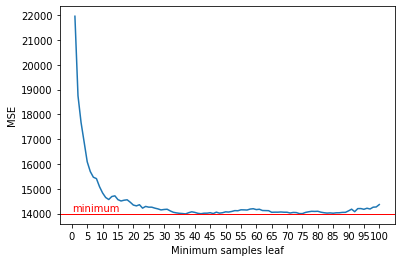

In [41]:
plt.plot(x, y)
plt.xlabel('Minimum samples leaf')
plt.ylabel('MSE')
plt.xticks(ticks=range(0, 101, 5))
plt.axhline(min(y), color='red', linewidth=1)
plt.text(0, 14100, "minimum", color='red')

The performance improves at a fast pace until we reach around 10. Then it keeps improving more slowly until it reaches the mininum at around 35, after which it seems to oscilate a bit up and down.

However, it's posible we overfit our model to the test data if we use it to tune our hyperparameters. We'll not have a clear idea about how our model would perform with unknown data. 

In order to solve that problem, we are going to use Kfold validation. 

In [42]:
kfold_results = {}
for msl in msl_list:
    kf = KFold(5, shuffle=True, random_state=1)
    tree = DecisionTreeRegressor(min_samples_leaf=msl)
    mses = cross_val_score(tree, train[features], train[target], scoring='neg_mean_squared_error', cv=kf)
    avg_mse = -np.mean(mses)
    kfold_results['min_samples_leaf ' + str(msl)] = avg_mse

In [43]:
kfold_results

{'min_samples_leaf 1': 22444.74497060029,
 'min_samples_leaf 2': 19257.42327701419,
 'min_samples_leaf 3': 17744.48545420869,
 'min_samples_leaf 4': 16779.676938159886,
 'min_samples_leaf 5': 15783.41193568517,
 'min_samples_leaf 6': 15445.12765371649,
 'min_samples_leaf 7': 15050.118866051553,
 'min_samples_leaf 8': 14967.791553539224,
 'min_samples_leaf 9': 14626.670630018649,
 'min_samples_leaf 10': 14285.948668542256,
 'min_samples_leaf 11': 14108.51678357562,
 'min_samples_leaf 12': 13877.776984929393,
 'min_samples_leaf 13': 13912.708484943922,
 'min_samples_leaf 14': 13875.490705878392,
 'min_samples_leaf 15': 13710.550252437053,
 'min_samples_leaf 16': 13732.282748541393,
 'min_samples_leaf 17': 13712.612126707676,
 'min_samples_leaf 18': 13733.166311009907,
 'min_samples_leaf 19': 13644.78752044488,
 'min_samples_leaf 20': 13616.321264050188,
 'min_samples_leaf 21': 13602.858019750633,
 'min_samples_leaf 22': 13602.410411898029,
 'min_samples_leaf 23': 13606.29535693851,
 'min

In [44]:
y_b = list(kfold_results.values())

In [45]:
y_b

[22444.74497060029,
 19257.42327701419,
 17744.48545420869,
 16779.676938159886,
 15783.41193568517,
 15445.12765371649,
 15050.118866051553,
 14967.791553539224,
 14626.670630018649,
 14285.948668542256,
 14108.51678357562,
 13877.776984929393,
 13912.708484943922,
 13875.490705878392,
 13710.550252437053,
 13732.282748541393,
 13712.612126707676,
 13733.166311009907,
 13644.78752044488,
 13616.321264050188,
 13602.858019750633,
 13602.410411898029,
 13606.29535693851,
 13619.836338915044,
 13572.157688940031,
 13545.099907581793,
 13531.16545085431,
 13563.356326745488,
 13533.160841608784,
 13510.59788306189,
 13505.912779067552,
 13554.835302376374,
 13547.416838755194,
 13529.660794763488,
 13530.492336448258,
 13483.234128299728,
 13380.171465019714,
 13396.046188241013,
 13419.688289859714,
 13425.658582856888,
 13433.799737110612,
 13470.017494796182,
 13467.088112362058,
 13442.383073983365,
 13433.181621209724,
 13468.713521208378,
 13425.319688216263,
 13448.321041002866,
 1

([<matplotlib.axis.XTick at 0x254ab4647c8>,
 <a list of 21 Text xticklabel objects>)

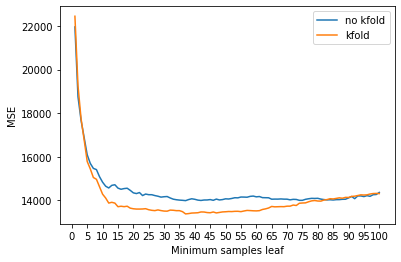

In [46]:
plt.plot(x, y, label='no kfold')
plt.plot(x, y_b, label='kfold')
plt.legend()
plt.xlabel('Minimum samples leaf')
plt.ylabel('MSE')
plt.xticks(ticks=range(0, 101, 5))


Now we choose the best value for minimum samples leaf, train a model with all the training data and finally use it on the test data. 

In [47]:
tree = DecisionTreeRegressor(min_samples_leaf=36)
tree.fit(train[features], train[target])
predictions = tree.predict(test[features])
error = mean_squared_error(predictions, test[target])
print(error)

14004.157953085189


Not bad!! We've definitely improved. Now let's check the `max_depth` hyperparameter.

In [48]:
depths = list(range(4, 21))

In [49]:
depths

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [50]:
max_depth_results = {}
for depth in depths:
    kf = KFold(5, shuffle=True, random_state=1)
    tree = DecisionTreeRegressor(min_samples_leaf=36, max_depth=depth)
    mses = cross_val_score(tree, train[features], train[target], scoring='neg_mean_squared_error', cv=kf)
    avg_mse = -np.mean(mses)
    max_depth_results['max_depth ' + str(depth)] = avg_mse

In [51]:
max_depth_results

{'max_depth 4': 16254.511496862742,
 'max_depth 5': 15473.69568413596,
 'max_depth 6': 14814.71107924089,
 'max_depth 7': 14365.347372893895,
 'max_depth 8': 13869.940117810484,
 'max_depth 9': 13594.00570286041,
 'max_depth 10': 13454.073779670794,
 'max_depth 11': 13467.674543890807,
 'max_depth 12': 13420.859795121305,
 'max_depth 13': 13457.314872597757,
 'max_depth 14': 13478.908692333542,
 'max_depth 15': 13483.245302065308,
 'max_depth 16': 13483.234128299728,
 'max_depth 17': 13483.245302065308,
 'max_depth 18': 13483.234128299728,
 'max_depth 19': 13483.245302065308,
 'max_depth 20': 13483.245302065308}

12 seems a good number! Let's try it now on our test set. 

In [52]:
tree = DecisionTreeRegressor(min_samples_leaf=36, max_depth=12)
tree.fit(train[features], train[target])
predictions = tree.predict(test[features])
error = mean_squared_error(predictions, test[target])
print(error)

13913.913835190773


That's a bit better than what we got with just the `min_samples_leaf` parameter optimized.  Our next step is to bring a bunch of decision tree together and create what we call a random forest model, which like decision trees can capture complex dynamics in the data and at the same time manages to avoid the overfitting of single decision trees. 

In [53]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators=50, random_state=1, min_samples_leaf=36, max_depth=12)
clf.fit(train[features], train[target])
predictions = clf.predict(test[features])
error = mean_squared_error(predictions, test[target])
error


13208.137235285583

It seems we managed to improve even more with the random forest algorithm. We could keep tweaking it but let's leave it here for now. 

To finish let's have a look at the predictions and the real numbers from the test set. We'll take a random sample of 50 from the set.

In [54]:
test['prediction_rand'] = predictions

In [55]:
print(test.sample(50)[['cnt', 'prediction_rand']].to_string(index=False))

 cnt  prediction_rand
 180       160.069598
  17         7.205029
 258       238.047151
  84        68.757190
  39        75.758349
  20        17.713050
 213       181.527998
   7         9.517393
 155       204.664975
 255       138.191394
 322       201.410920
 304       314.037253
  33        20.879333
  28        17.822840
 252       101.320450
 376       274.908723
 104       138.933609
 579       513.464148
 359       362.405265
 131       405.206194
 263       408.834138
 431       262.038759
  10        19.333948
 226       196.139166
  26        25.945419
 409       309.555335
 145       189.497542
  59       208.926737
 243       363.172636
 604       264.644658
 290       403.754598
   5         5.732850
  65       217.080783
  40        18.494338
 338       450.280020
  24        11.521443
 455       396.496520
  12         8.930308
 251       303.060139
 231       297.111089
   6        16.185883
 187       264.795110
  63        90.877335
 231       259.359142
 159      

Not so bad. Although our model is far from perfect, we can see it manages to capture some of the underlying dynamics of the data. There are several things we could do in order to keep improving our predictive power, like feature engineering and model tuning, and those changes will be worked on in the future.